## Importing packages

In [267]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from skimage.filters import sobel, sobel_h, sobel_v
import glob
import re
import tifffile as tiff
import zarr
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks

(z,channels,x,y) (16, 2, 3200, 3200)
(42, 3200, 3200)
    peak_heights    prominences  left_bases  right_bases     widths  \
0  188613.458855  181524.755241          34         1487  18.667498   
1  173748.168088  167022.507679         454          798  18.569738   
2  175835.200334  169267.157815         425         1485  18.677548   
3  135557.487635  129253.849422        1122         1485  18.240048   
4  158356.957164  152301.098262        1474         2009  18.110570   
5  164890.459607  158044.278266        2019         2614  17.777474   
7  865971.293907  858984.149104        2110         3080  19.606952   

   width_heights     left_ips    right_ips  peak_locations  index  \
0   97851.081234   172.825769   191.493267             182      9   
1   90236.914248   599.036680   617.606418             608      8   
2   91201.621426   917.770960   936.448508             927      7   
3   70930.562924  1238.616722  1256.856770            1248      7   
4   82206.408033  1770.472486  1

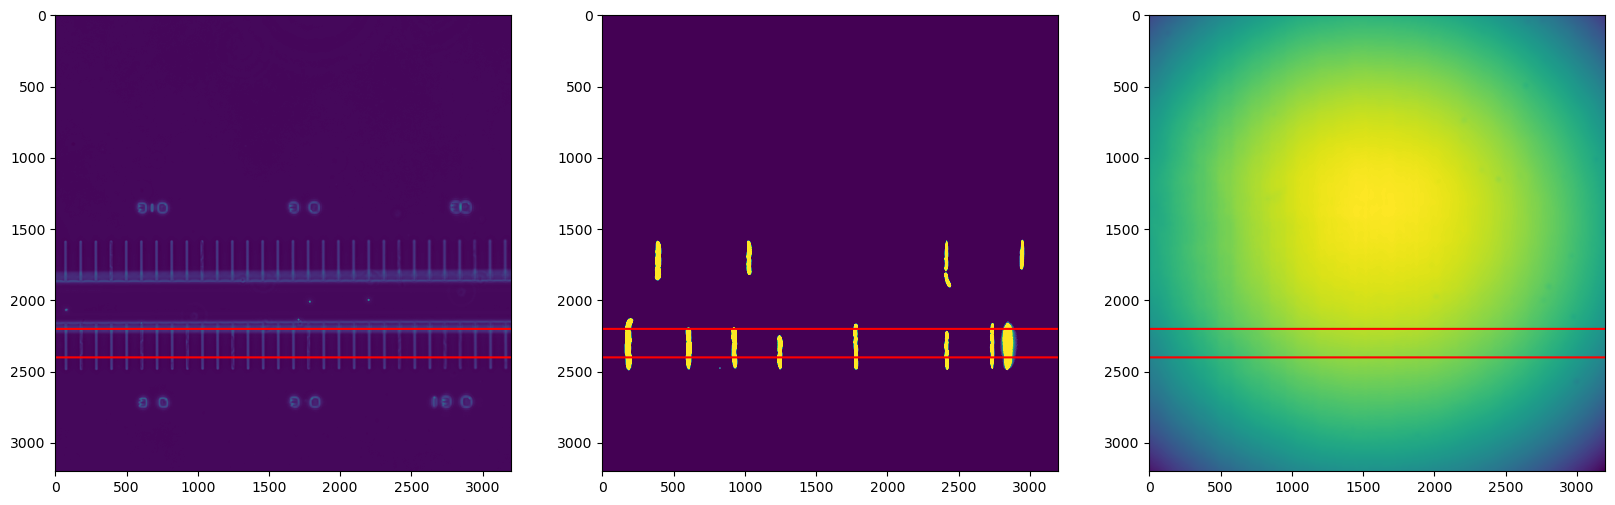

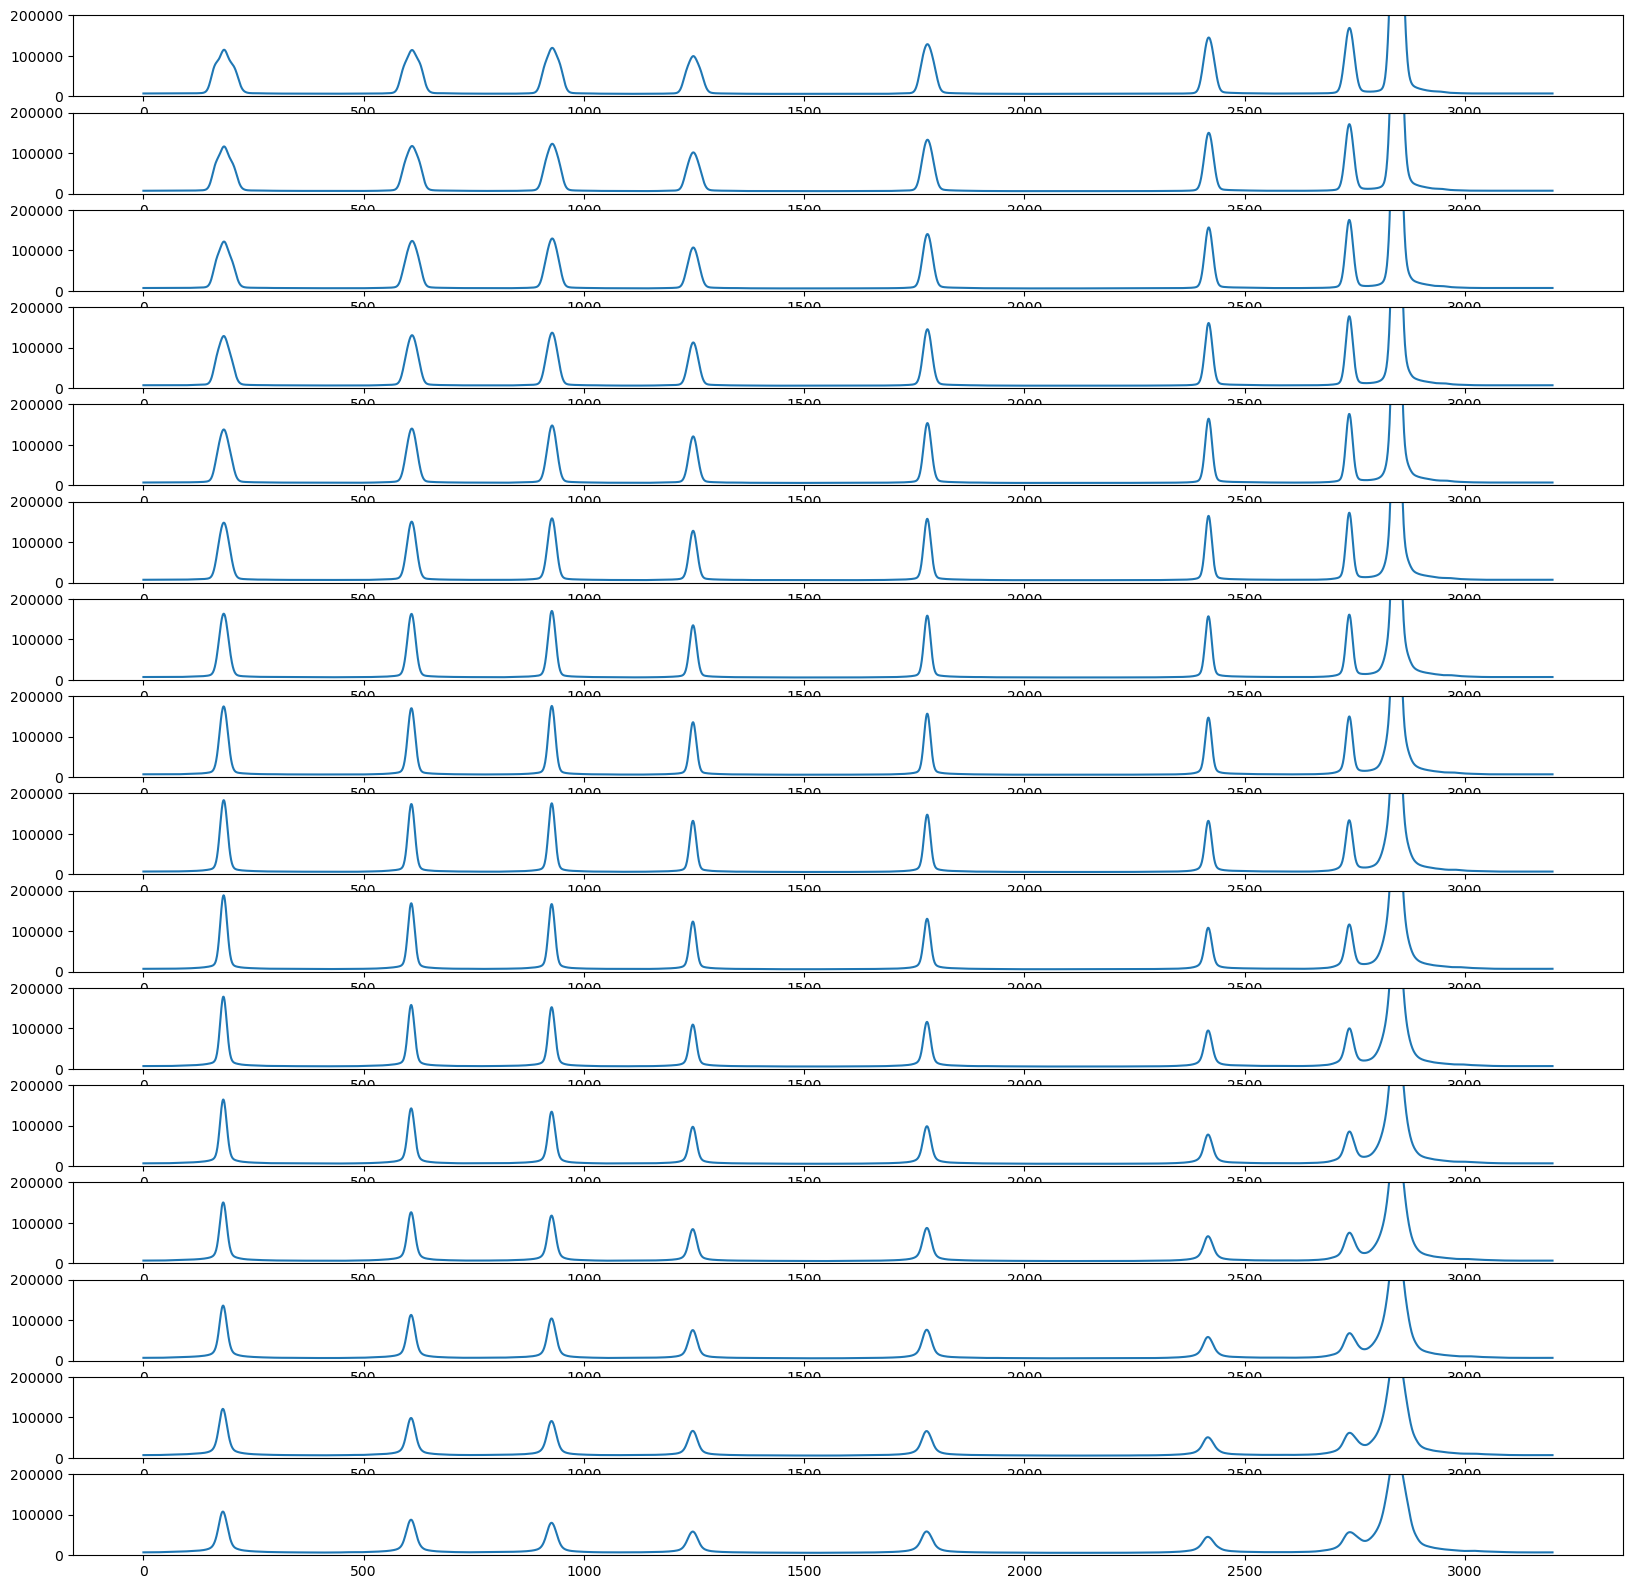

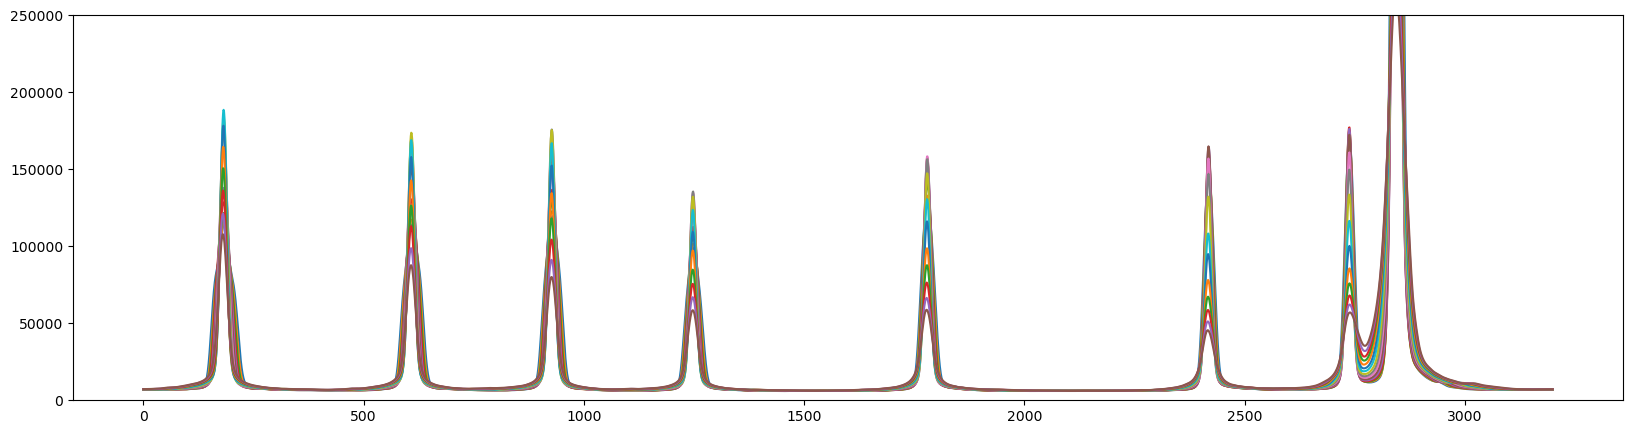

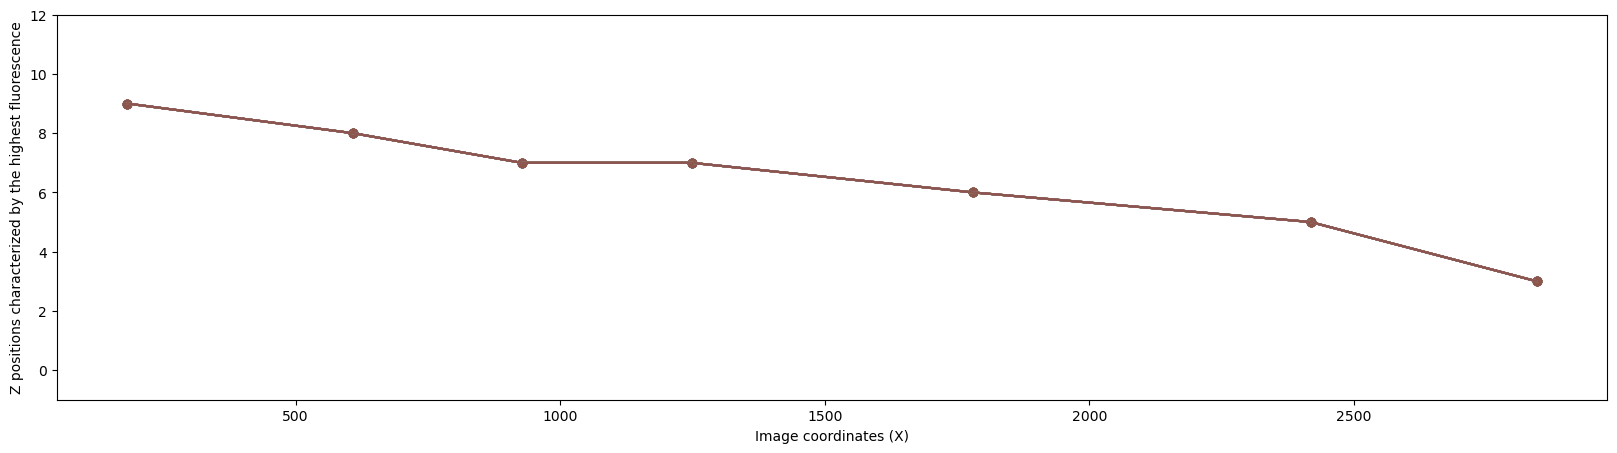

In [283]:
#Write a useful function
zstack_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20221114_zstacks_study/20221114_zstacks_corrected/20221114_zstacks_corrected_2/20221114_zstacks_corrected_2_MMStack.ome.tif"
ymin=2200
ymax=2400

#Do not edit below
## Import data, compute min and max fluorescence values, m and M
im = io.imread(zstack_path)
print("(z,channels,x,y)",im.shape)
M=np.max(im[:,1,ymin:ymax,:])
m=np.min(im[:,1,ymin:ymax,:])
#print(m,M)
#print(np.histogram(im[:,1,ymin:ymax,:]))
#print(np.histogram(im[:,1,ymin:ymax,:]-m))
#plt.hist(np.histogram(im[:,1,ymin:ymax,:]))
#plt.xscale('log')

## Plot images in phase contrast and fluorescence channel, with correct ranges
fig,axs=plt.subplots(1,3,squeeze=False)
fig.set_size_inches(20,40)
axs[0,0].imshow(im[10,0,:,:])
#plt.xticks(np.linspace(0,3200,40))
#plt.yticks(np.linspace(0,3200,40))
axs[0,0].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,0].plot(range(0,3200),[ymax]*3200,color="red")
#plt.colorbar()

axs[0,1].imshow(im[5,1,:,:]-m,vmin=m,vmax=2*m)
#axs[0,1].xticks(np.linspace(0,3200,40))
#axs[0,1].yticks(np.linspace(0,3200,40))
axs[0,1].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,1].plot(range(0,3200),[ymax]*3200,color="red")
#axs[0,1].colorbar()

flat_field_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20221108/20221110_gfpflatfield/20221110_gfpflatfield_2/20221110_gfpflatfield_2_MMStack.ome.tif"
flat_field=tiff.TiffFile(flat_field_path)
flat_field_stack=[]
for p in flat_field.series:
    flat_field_stack.append(np.array(zarr.open(p.aszarr(),mode='r')))
flat_field_stack=np.array(flat_field_stack)
print(flat_field_stack.shape)
treated_flat_field=np.mean((flat_field_stack-85),axis=0)
treated_flat_field=gaussian_filter(treated_flat_field, 10)
treated_flat_field=treated_flat_field/np.max(treated_flat_field)

axs[0,2].imshow(treated_flat_field)
#plt.xticks(np.linspace(0,3200,40))
#plt.yticks(np.linspace(0,3200,40))
axs[0,2].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,2].plot(range(0,3200),[ymax]*3200,color="red")
#plt.colorbar()

im_gfp=im[:,1,:,:]-m
depth=im_gfp.shape[0]
treated_flat_field_final=np.array([treated_flat_field]*depth)
treated_flat_field_final.shape
im_gfp_corrected=gaussian_filter1d(np.divide(im_gfp,treated_flat_field),5)

fig,axs=plt.subplots(im.shape[0],1,squeeze=False)
fig.set_size_inches(20,20)
for i in range(0,im.shape[0]):
    to_plot=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    axs[i,0].plot(range(0,3200),to_plot)
    axs[i,0].set_ylim([0,200000])
    
fig,axs=plt.subplots(1,1,squeeze=False)
fig.set_size_inches(20,5)
for i in range(0,im.shape[0]):
    to_plot=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    axs[0,0].plot(range(0,3200),to_plot)
    axs[0,0].set_ylim([0,250000])
    
    
list_of_peaks=[]
for i in range(0,im_gfp_corrected.shape[0]):
    data=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    list_of_peaks+=[find_peaks(data,height=20000,width=10)]

df_of_peaks=[makeDataFrame(list_of_peaks[e],e) for e in range(0,len(list_of_peaks))]
mydf=pd.concat(df_of_peaks,axis=0)
mydf.to_csv('mydf_counting_peaks.csv')
summary=mydf.groupby(['index']).count()
summary.to_csv('summary.csv')
df_of_peaks=[makeDataFrame(list_of_peaks[e],e) for e in range(0,len(list_of_peaks))]
mydf=pd.concat(df_of_peaks,axis=0)
mydf.to_csv('mydf_counting_peaks.csv')
summary=mydf.groupby(['index']).count()
summary.to_csv('summary.csv')
mydf['peak_locations_binned']=pd.cut(mydf['peak_locations'],12)
mydf['max_peak_heights']=mydf.groupby(['peak_locations_binned'])['peak_heights'].transform('max')
mydf=mydf.query('peak_heights==max_peak_heights')
mydf=mydf.sort_values(by='peak_locations_binned')
#mydf.to_csv('view.csv')
print(mydf)

fig,axs=plt.subplots(1,1,squeeze=False)
fig.set_size_inches(20,5)
for i in range(0,im.shape[0]):
    axs[0,0].plot(mydf['peak_locations'],mydf['index'])
    axs[0,0].scatter(mydf['peak_locations'],mydf['index'])
    axs[0,0].set_ylim([-1,12])
    axs[0,0].set_xlabel('Image coordinates (X)')
    axs[0,0].set_ylabel('Z positions characterized by the highest fluorescence')

(z,channels,x,y) (17, 2, 3200, 3200)
(42, 3200, 3200)
    peak_heights    prominences  left_bases  right_bases     widths  \
0  165915.823346  154310.850297           0          257  19.071562   
1  202405.676737  195709.871398         286         1873  18.883369   
3  157125.736515  145455.513958         640         1101  17.479264   
5  164704.157312  158667.396851        1101         1957  17.494988   
6  185654.954492  179260.445961        1852         2605  17.292233   
8  154473.634120  145813.446400        2576         3199  17.062862   

   width_heights     left_ips    right_ips  peak_locations  index  \
0   88760.398197    42.236912    61.308473              52      2   
1  104550.741037   467.478761   486.362130             477      3   
3   84397.979536   681.239978   698.719242             690      4   
5   85370.458887  1320.614531  1338.109519            1329      5   
6   96024.731512  2385.199703  2402.491936            2394      7   
8   81566.910920  3130.263812  314

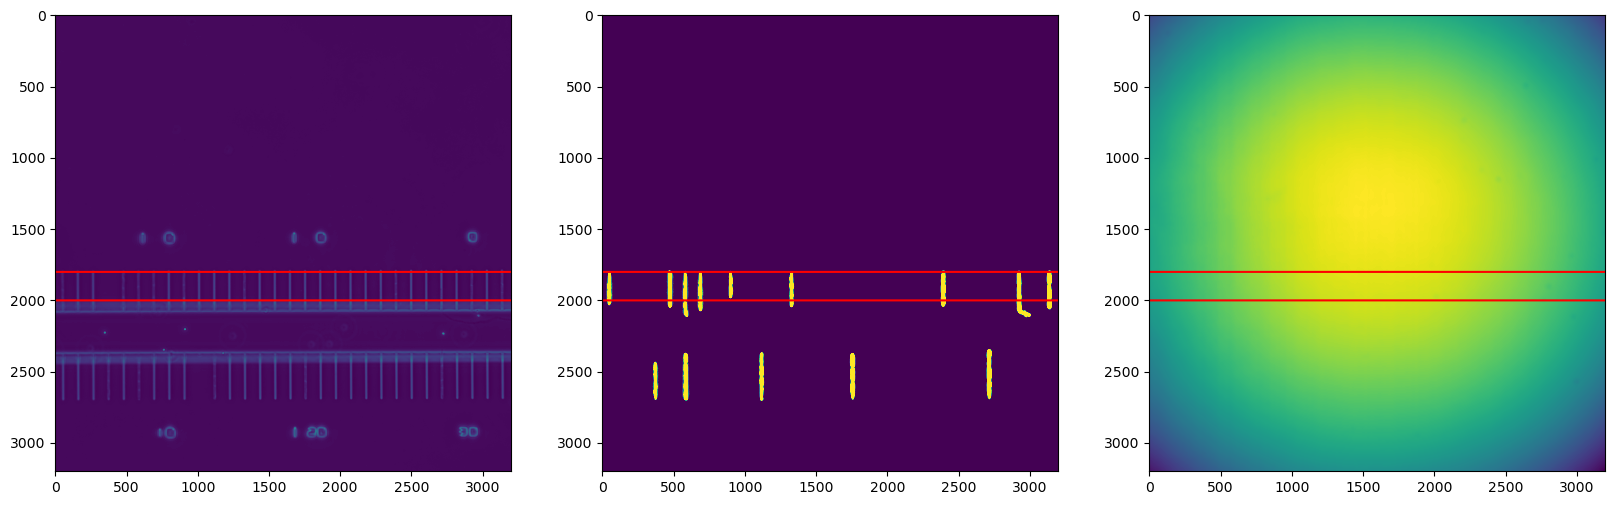

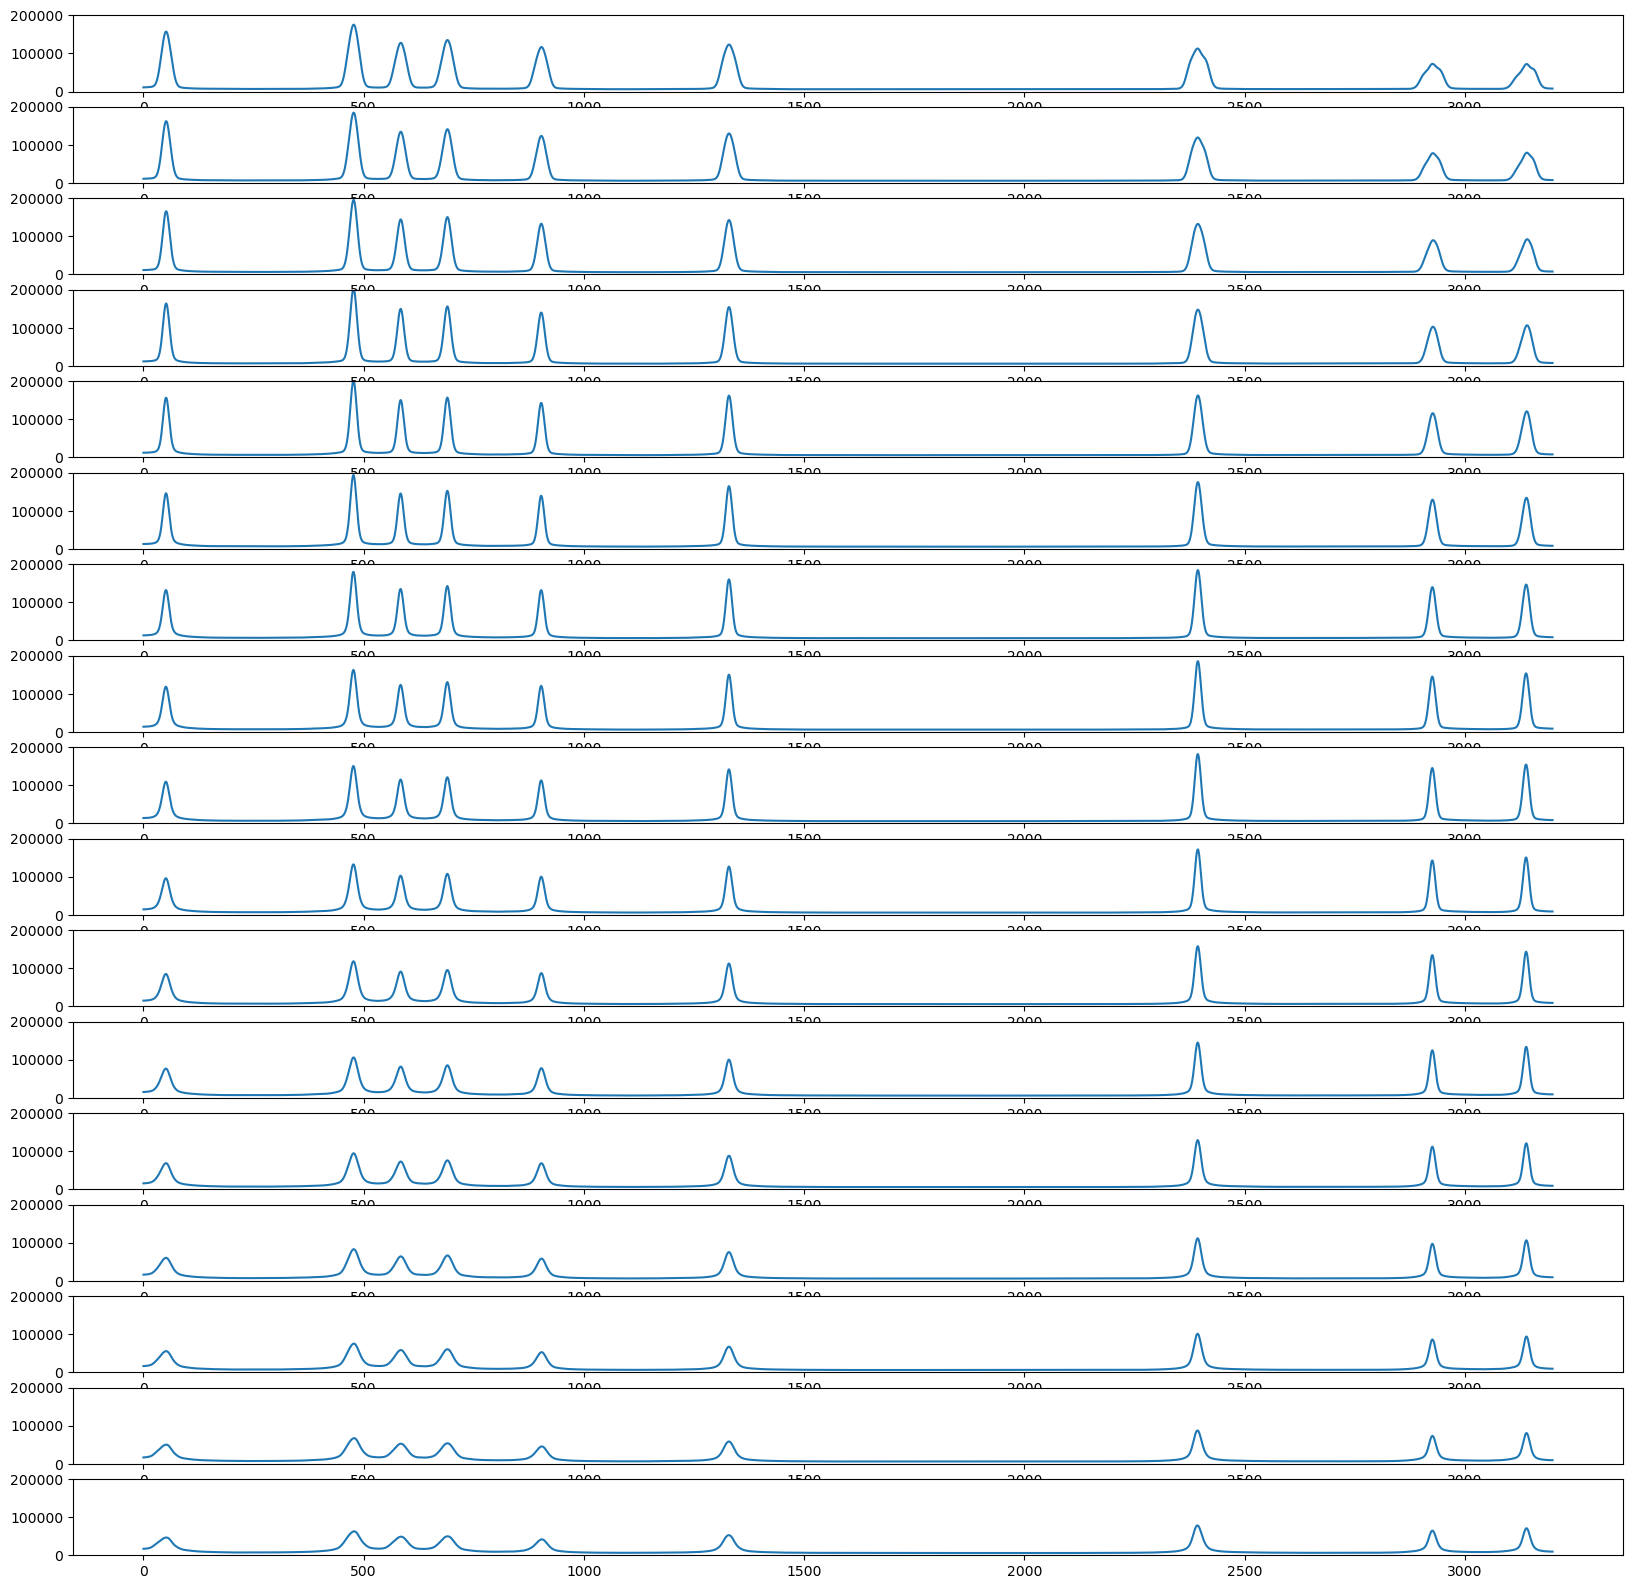

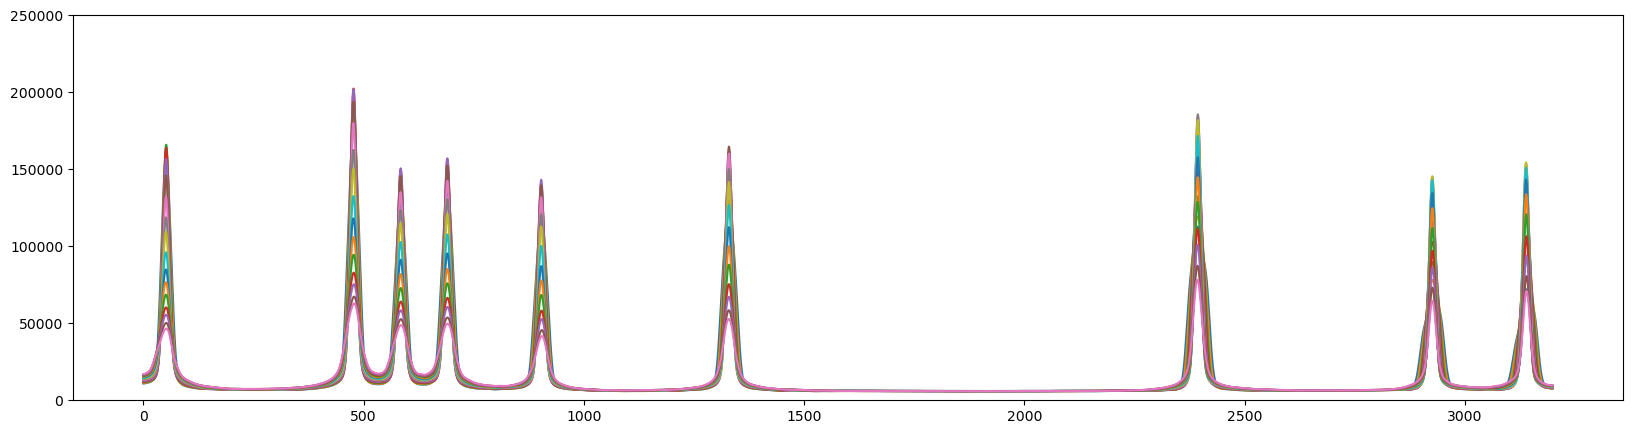

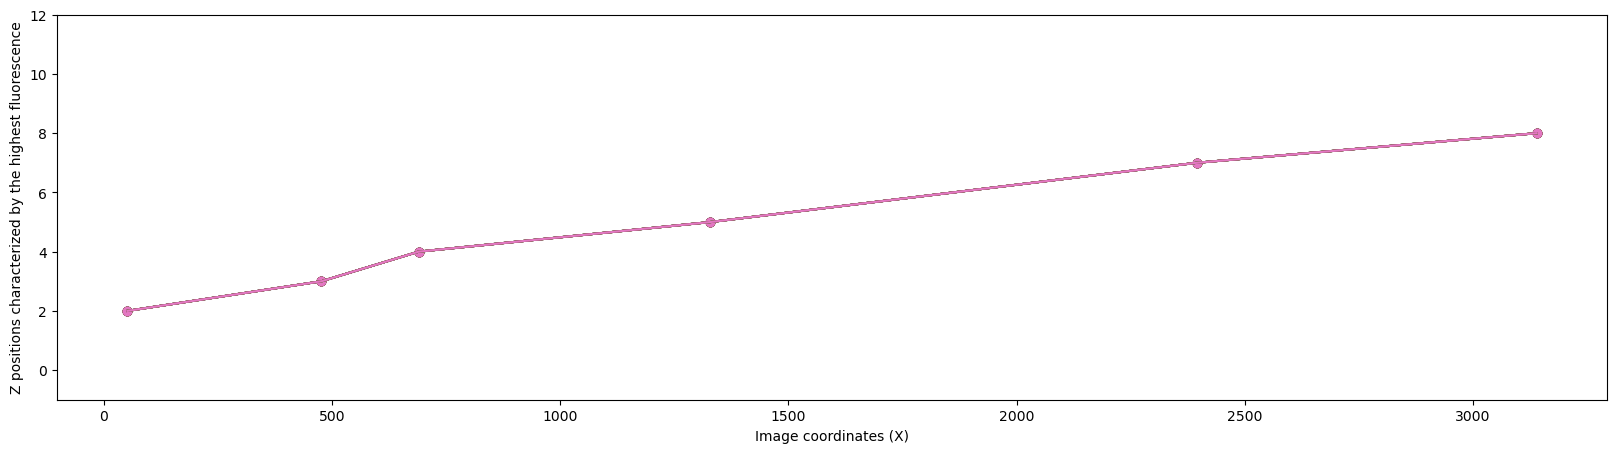

In [284]:
#Write a useful function
zstack_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20221114_zstacks_study/20221114_zstacks_corrected/20221114_zstacks_corrected_3/20221114_zstacks_corrected_3_MMStack.ome.tif"
ymin=1800
ymax=2000

#Do not edit below
## Import data, compute min and max fluorescence values, m and M
im = io.imread(zstack_path)
print("(z,channels,x,y)",im.shape)
M=np.max(im[:,1,ymin:ymax,:])
m=np.min(im[:,1,ymin:ymax,:])
#print(m,M)
#print(np.histogram(im[:,1,ymin:ymax,:]))
#print(np.histogram(im[:,1,ymin:ymax,:]-m))
#plt.hist(np.histogram(im[:,1,ymin:ymax,:]))
#plt.xscale('log')

## Plot images in phase contrast and fluorescence channel, with correct ranges
fig,axs=plt.subplots(1,3,squeeze=False)
fig.set_size_inches(20,40)
axs[0,0].imshow(im[10,0,:,:])
#plt.xticks(np.linspace(0,3200,40))
#plt.yticks(np.linspace(0,3200,40))
axs[0,0].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,0].plot(range(0,3200),[ymax]*3200,color="red")
#plt.colorbar()

axs[0,1].imshow(im[5,1,:,:]-m,vmin=m,vmax=2*m)
#axs[0,1].xticks(np.linspace(0,3200,40))
#axs[0,1].yticks(np.linspace(0,3200,40))
axs[0,1].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,1].plot(range(0,3200),[ymax]*3200,color="red")
#axs[0,1].colorbar()

flat_field_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20221108/20221110_gfpflatfield/20221110_gfpflatfield_2/20221110_gfpflatfield_2_MMStack.ome.tif"
flat_field=tiff.TiffFile(flat_field_path)
flat_field_stack=[]
for p in flat_field.series:
    flat_field_stack.append(np.array(zarr.open(p.aszarr(),mode='r')))
flat_field_stack=np.array(flat_field_stack)
print(flat_field_stack.shape)
treated_flat_field=np.mean((flat_field_stack-85),axis=0)
treated_flat_field=gaussian_filter(treated_flat_field, 10)
treated_flat_field=treated_flat_field/np.max(treated_flat_field)

axs[0,2].imshow(treated_flat_field)
#plt.xticks(np.linspace(0,3200,40))
#plt.yticks(np.linspace(0,3200,40))
axs[0,2].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,2].plot(range(0,3200),[ymax]*3200,color="red")
#plt.colorbar()

im_gfp=im[:,1,:,:]-m
depth=im_gfp.shape[0]
treated_flat_field_final=np.array([treated_flat_field]*depth)
treated_flat_field_final.shape
im_gfp_corrected=gaussian_filter1d(np.divide(im_gfp,treated_flat_field),5)

fig,axs=plt.subplots(im.shape[0],1,squeeze=False)
fig.set_size_inches(20,20)
for i in range(0,im.shape[0]):
    to_plot=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    axs[i,0].plot(range(0,3200),to_plot)
    axs[i,0].set_ylim([0,200000])
    
fig,axs=plt.subplots(1,1,squeeze=False)
fig.set_size_inches(20,5)
for i in range(0,im.shape[0]):
    to_plot=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    axs[0,0].plot(range(0,3200),to_plot)
    axs[0,0].set_ylim([0,250000])
    
    
list_of_peaks=[]
for i in range(0,im_gfp_corrected.shape[0]):
    data=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    list_of_peaks+=[find_peaks(data,height=20000,width=10)]

df_of_peaks=[makeDataFrame(list_of_peaks[e],e) for e in range(0,len(list_of_peaks))]
mydf=pd.concat(df_of_peaks,axis=0)
mydf.to_csv('mydf_counting_peaks.csv')
summary=mydf.groupby(['index']).count()
summary.to_csv('summary.csv')
df_of_peaks=[makeDataFrame(list_of_peaks[e],e) for e in range(0,len(list_of_peaks))]
mydf=pd.concat(df_of_peaks,axis=0)
mydf.to_csv('mydf_counting_peaks.csv')
summary=mydf.groupby(['index']).count()
summary.to_csv('summary.csv')
mydf['peak_locations_binned']=pd.cut(mydf['peak_locations'],10)
mydf['max_peak_heights']=mydf.groupby(['peak_locations_binned'])['peak_heights'].transform('max')
mydf=mydf.query('peak_heights==max_peak_heights')
mydf=mydf.sort_values(by='peak_locations_binned')
#mydf.to_csv('view.csv')
print(mydf)

fig,axs=plt.subplots(1,1,squeeze=False)
fig.set_size_inches(20,5)
for i in range(0,im.shape[0]):
    axs[0,0].plot(mydf['peak_locations'],mydf['index'])
    axs[0,0].scatter(mydf['peak_locations'],mydf['index'])
    axs[0,0].set_ylim([-1,12])
    axs[0,0].set_xlabel('Image coordinates (X)')
    axs[0,0].set_ylabel('Z positions characterized by the highest fluorescence')

(z,channels,x,y) (18, 2, 3200, 3200)
(42, 3200, 3200)
    peak_heights    prominences  left_bases  right_bases     widths  \
0  130882.316309  123739.763298          33         1296  17.824572   
1  120998.218481  114579.042721         862         1340  18.379200   
2  133503.146340  126982.061501        1340         1761  18.379574   
3  139213.191147  131846.752913        1296         2030  17.822515   
5  180206.387082  173605.214723        1340         2538  18.598275   
7   94929.226221   87918.086243        2567         3042  17.200319   

   width_heights     left_ips    right_ips  peak_locations  index  \
0   69012.434660   183.369989   201.194562             192     11   
1   63708.697120  1035.020442  1053.399642            1044     10   
2   70012.115590  1567.132828  1585.512402            1576     10   
3   73289.814691  1887.226434  1905.048949            1896     11   
5   93403.779721  2206.805800  2225.404075            2216     10   
7   50970.183100  2847.103736  286

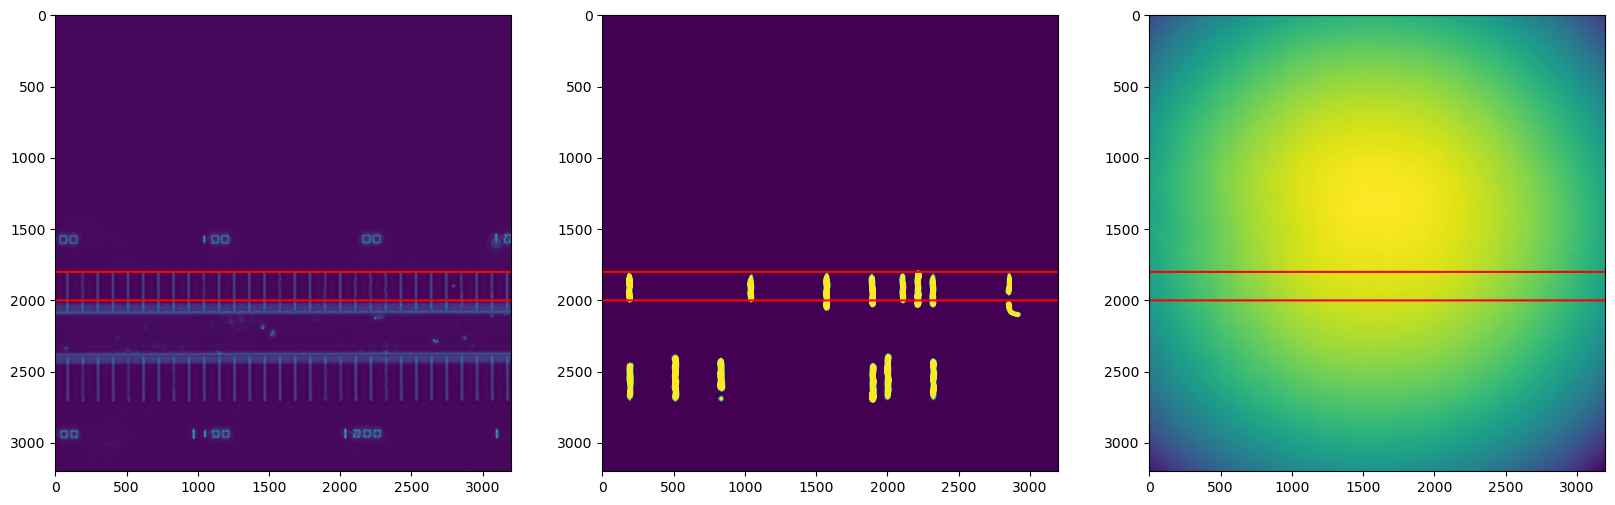

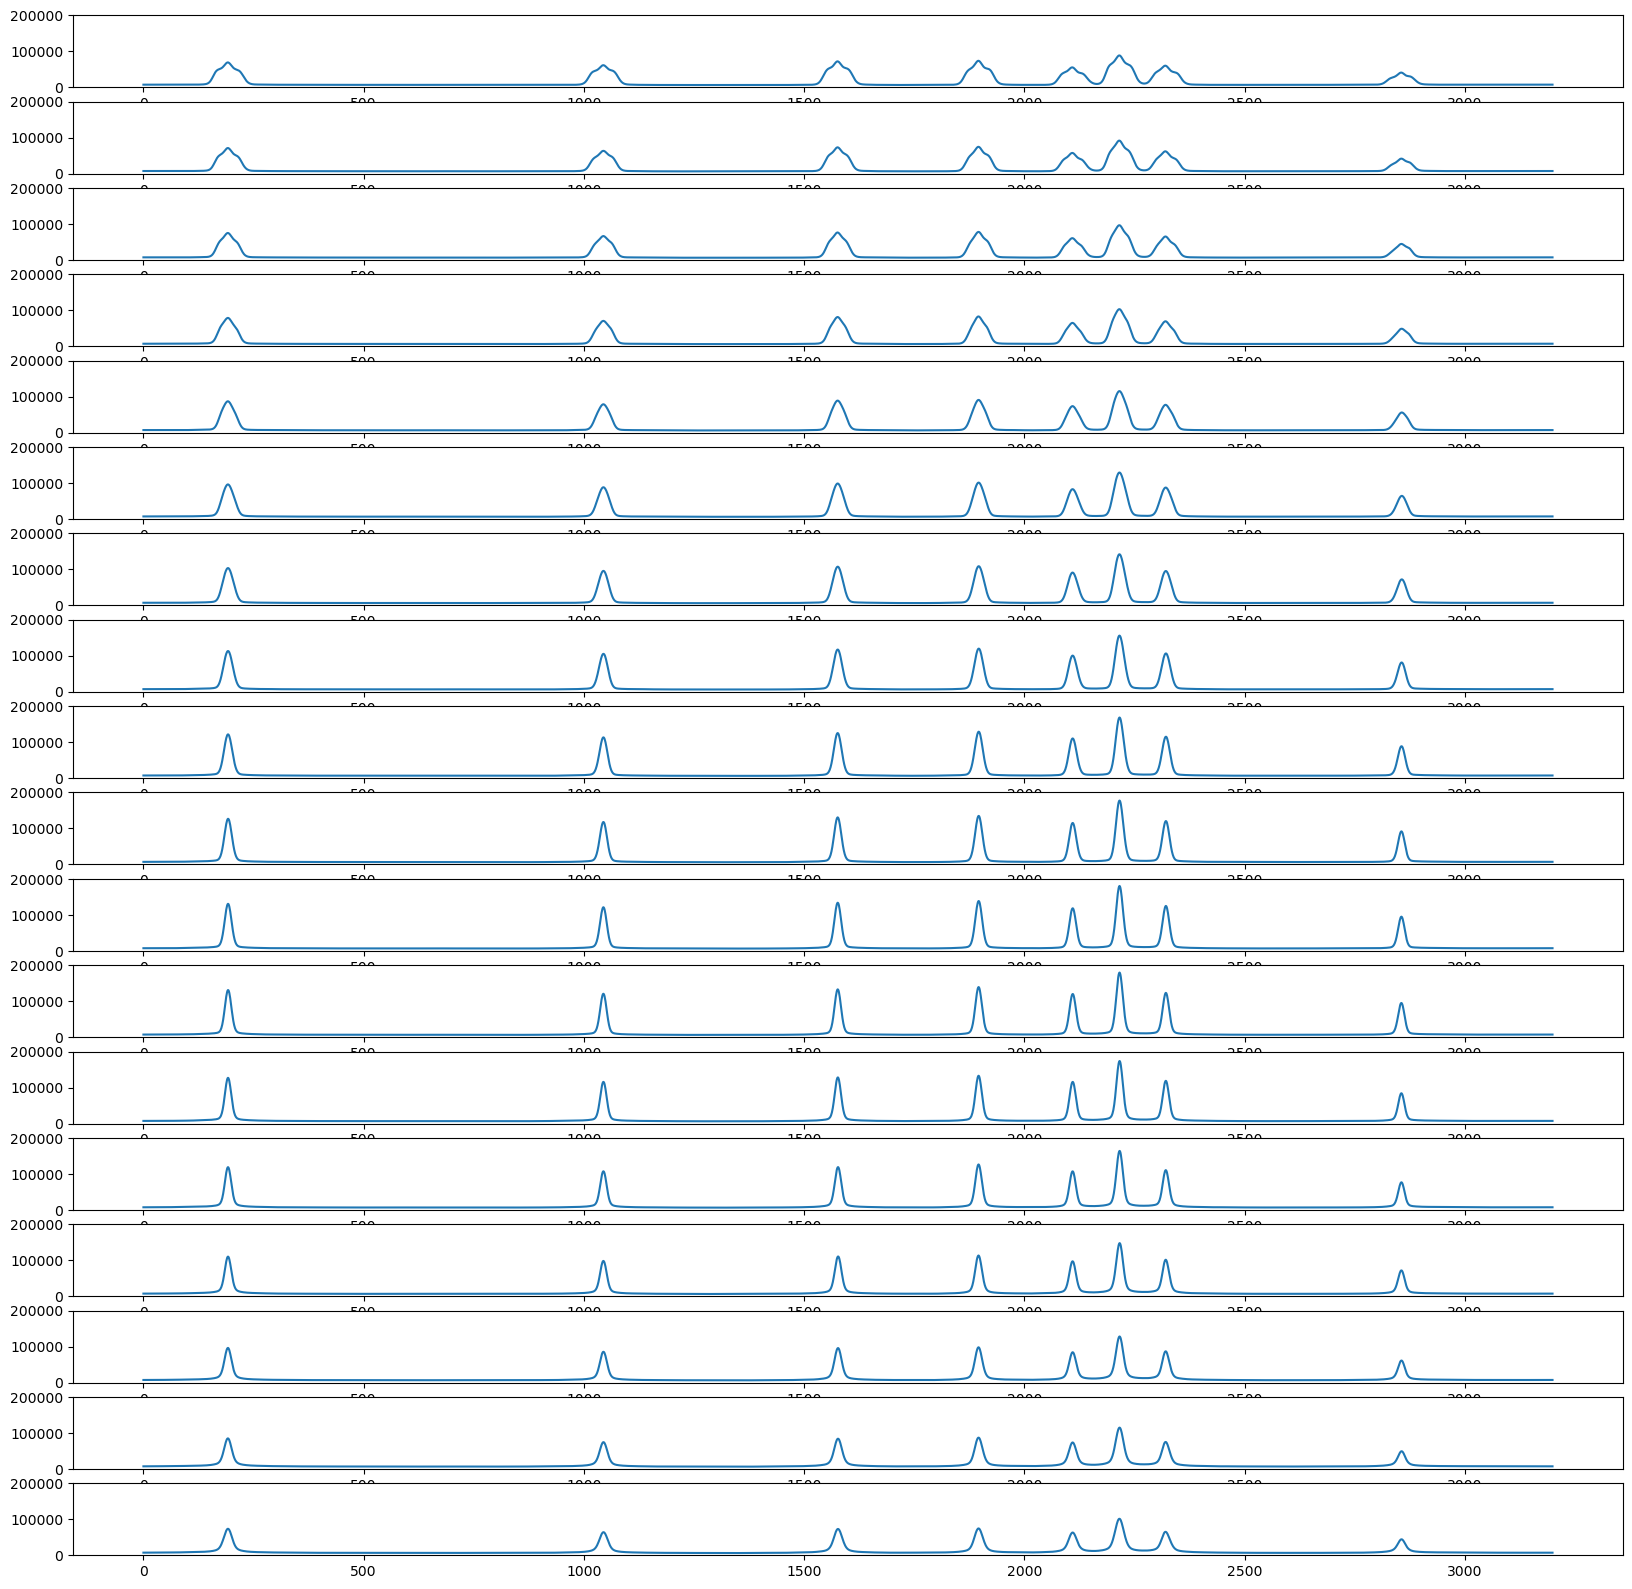

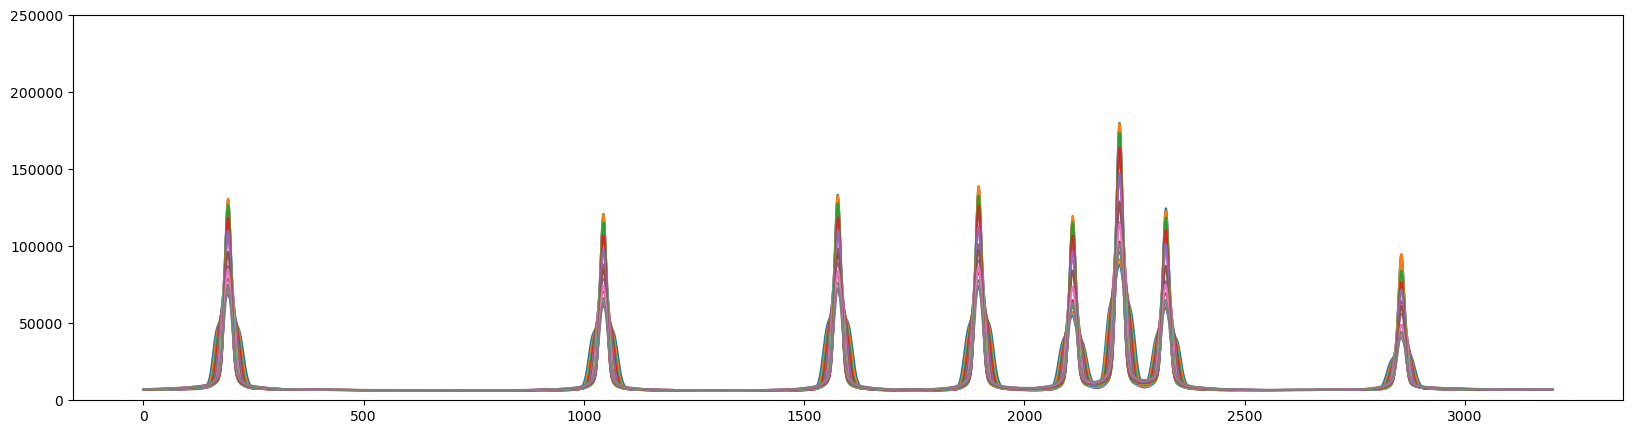

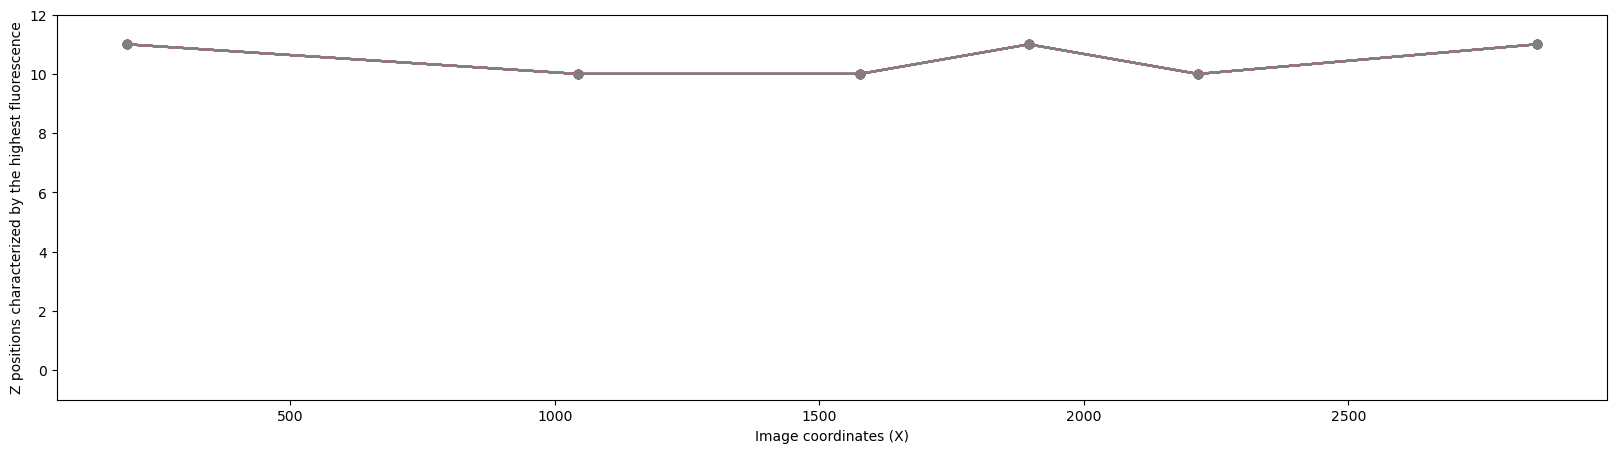

In [286]:
#Write a useful function
zstack_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20221114_zstacks_study/20221114_zstacks_corrected/20221114_zstacks_corrected_4/20221114_zstacks_corrected_4_MMStack.ome.tif"
ymin=1800
ymax=2000

#Do not edit below
## Import data, compute min and max fluorescence values, m and M
im = io.imread(zstack_path)
print("(z,channels,x,y)",im.shape)
M=np.max(im[:,1,ymin:ymax,:])
m=np.min(im[:,1,ymin:ymax,:])
#print(m,M)
#print(np.histogram(im[:,1,ymin:ymax,:]))
#print(np.histogram(im[:,1,ymin:ymax,:]-m))
#plt.hist(np.histogram(im[:,1,ymin:ymax,:]))
#plt.xscale('log')

## Plot images in phase contrast and fluorescence channel, with correct ranges
fig,axs=plt.subplots(1,3,squeeze=False)
fig.set_size_inches(20,40)
axs[0,0].imshow(im[10,0,:,:])
#plt.xticks(np.linspace(0,3200,40))
#plt.yticks(np.linspace(0,3200,40))
axs[0,0].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,0].plot(range(0,3200),[ymax]*3200,color="red")
#plt.colorbar()

axs[0,1].imshow(im[5,1,:,:]-m,vmin=m,vmax=2*m)
#axs[0,1].xticks(np.linspace(0,3200,40))
#axs[0,1].yticks(np.linspace(0,3200,40))
axs[0,1].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,1].plot(range(0,3200),[ymax]*3200,color="red")
#axs[0,1].colorbar()

flat_field_path="/scicore/home/nimwegen/rocasu25/MM_Data/Dany/20221108/20221110_gfpflatfield/20221110_gfpflatfield_2/20221110_gfpflatfield_2_MMStack.ome.tif"
flat_field=tiff.TiffFile(flat_field_path)
flat_field_stack=[]
for p in flat_field.series:
    flat_field_stack.append(np.array(zarr.open(p.aszarr(),mode='r')))
flat_field_stack=np.array(flat_field_stack)
print(flat_field_stack.shape)
treated_flat_field=np.mean((flat_field_stack-85),axis=0)
treated_flat_field=gaussian_filter(treated_flat_field, 10)
treated_flat_field=treated_flat_field/np.max(treated_flat_field)

axs[0,2].imshow(treated_flat_field)
#plt.xticks(np.linspace(0,3200,40))
#plt.yticks(np.linspace(0,3200,40))
axs[0,2].plot(range(0,3200),[ymin]*3200,color="red")
axs[0,2].plot(range(0,3200),[ymax]*3200,color="red")
#plt.colorbar()

im_gfp=im[:,1,:,:]-m
depth=im_gfp.shape[0]
treated_flat_field_final=np.array([treated_flat_field]*depth)
treated_flat_field_final.shape
im_gfp_corrected=gaussian_filter1d(np.divide(im_gfp,treated_flat_field),5)

fig,axs=plt.subplots(im.shape[0],1,squeeze=False)
fig.set_size_inches(20,20)
for i in range(0,im.shape[0]):
    to_plot=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    axs[i,0].plot(range(0,3200),to_plot)
    axs[i,0].set_ylim([0,200000])
    
fig,axs=plt.subplots(1,1,squeeze=False)
fig.set_size_inches(20,5)
for i in range(0,im.shape[0]):
    to_plot=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    axs[0,0].plot(range(0,3200),to_plot)
    axs[0,0].set_ylim([0,250000])

    
list_of_peaks=[]
for i in range(0,im_gfp_corrected.shape[0]):
    data=np.sum(im_gfp_corrected[i,ymin:ymax,:],axis=0)
    list_of_peaks+=[find_peaks(data,height=20000,width=10)]

df_of_peaks=[makeDataFrame(list_of_peaks[e],e) for e in range(0,len(list_of_peaks))]
mydf=pd.concat(df_of_peaks,axis=0)
mydf.to_csv('mydf_counting_peaks.csv')
summary=mydf.groupby(['index']).count()
summary.to_csv('summary.csv')
df_of_peaks=[makeDataFrame(list_of_peaks[e],e) for e in range(0,len(list_of_peaks))]
mydf=pd.concat(df_of_peaks,axis=0)
mydf.to_csv('mydf_counting_peaks.csv')
summary=mydf.groupby(['index']).count()
summary.to_csv('summary.csv')



mydf['peak_locations_binned']=pd.cut(mydf['peak_locations'],10)
mydf['max_peak_heights']=mydf.groupby(['peak_locations_binned'])['peak_heights'].transform('max')
mydf=mydf.query('peak_heights==max_peak_heights')
mydf=mydf.sort_values(by='peak_locations_binned')
#mydf.to_csv('view.csv')
print(mydf)

fig,axs=plt.subplots(1,1,squeeze=False)
fig.set_size_inches(20,5)
for i in range(0,im.shape[0]):
    axs[0,0].plot(mydf['peak_locations'],mydf['index'])
    axs[0,0].scatter(mydf['peak_locations'],mydf['index'])
    axs[0,0].set_ylim([-1,12])
    axs[0,0].set_xlabel('Image coordinates (X)')
    axs[0,0].set_ylabel('Z positions characterized by the highest fluorescence')